* 2018-12-19 @Huang: based on Italy's "variables_derivation"

In [58]:
# impirt important packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.display.max_columns = None  # show all columns

In [5]:
# read data
airline_data = pd.read_csv('../../data/dataset/airline.csv')
# cache_map_data = pd.read_csv('../../data/dataset/cache_map.csv')
group_data = pd.read_csv('../../data/dataset/group.csv')
order_data = pd.read_csv('../../data/dataset/order.csv')
day_schedule_data = pd.read_csv('../../data/dataset/day_schedule.csv')

#
column_names = ['AirportID', 'Name', 'City', 'Country', 'IATA', 'ICAO', 'Latitude', 'Longitude', 
              'Altitude', 'Timezone', 'DST', 'TZ', 'Type','Source']
df_airport = pd.read_csv('../../data/airport.csv', names=column_names) #ref: https://openflights.org/data.html#airport

# test and train data
train_data = pd.read_csv('../../data/training-set.csv')
test_data = pd.read_csv('../../data/testing-set.csv')

/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### 處理訂單變數

In [6]:
order_data['order_date_dt'] = pd.to_datetime(order_data.order_date, format='%d-%b-%y') # ref: http://strftime.org/
order_data['order_year'] = order_data.order_date_dt.dt.year
order_data['order_month'] = order_data.order_date_dt.dt.month
order_data['order_day'] = order_data.order_date_dt.dt.day
order_data['order_dayofyear'] = order_data.order_date_dt.dt.dayofyear
order_data['order_weekday'] = order_data.order_date_dt.dt.dayofweek # 0=Mon, 6=Sun
order_data['unit']=order_data.unit.str.replace('unit_value_', '').astype(int)
order_data['source_1']=order_data.source_1.str.replace('src1_value_', '')
order_data['source_2']=order_data.source_2.str.replace('src2_value_', '')

### 處理group變數

In [7]:
group_data['sub_line'] = group_data.sub_line.str.replace('subline_value_','')
group_data['area'] = group_data.area.str.replace('area_value_','')
group_data['begin_date_dt'] = pd.to_datetime(group_data.begin_date, format='%d-%b-%y')
group_data['begin_year'] = group_data.begin_date_dt.dt.year
group_data['begin_month'] = group_data.begin_date_dt.dt.month
group_data['begin_day'] = group_data.begin_date_dt.dt.day
group_data['begin_dayofyear'] = group_data.begin_date_dt.dt.dayofyear
group_data['begin_weekday'] = group_data.begin_date_dt.dt.dayofweek # 0=Mon, 6=Sun
group_data['end_date_dt'] = group_data.begin_date_dt + group_data['days'].apply(np.ceil).apply(lambda x: pd.Timedelta(x, unit='D'))
group_data['end_year'] = group_data.end_date_dt.dt.year
group_data['end_month'] = group_data.end_date_dt.dt.month
group_data['end_day'] = group_data.end_date_dt.dt.day
group_data['end_dayofyear'] = group_data.end_date_dt.dt.dayofyear
group_data['end_weekday'] = group_data.end_date_dt.dt.dayofweek # 0=Mon, 6=Sun

### 處理航班變數

In [8]:
#
airline_data['dst_airport'] = airline_data.dst_airport.str.replace('([A-Z]+) ([^A-Z]+)','\\1')
airline_data['src_airport'] = airline_data.src_airport.str.replace('([A-Z]+) ([^A-Z]+)','\\1')
airline_data['go_back'] = airline_data.go_back.str.replace('去程', 'go')
airline_data['go_back'] = airline_data.go_back.str.replace('回程', 'back')

# unify time, compute the travel time for each routes
airline_data['src_IATA'] = airline_data.src_airport.str.replace('([A-Z]+) ([^A-Z])+', '\\1')
airline_data['dst_IATA'] = airline_data.dst_airport.str.replace('([A-Z]+) ([^A-Z])+', '\\1')
tmp = pd.merge(airline_data, df_airport[['IATA','TZ']], left_on='src_IATA', right_on='IATA', how='left')
airline_data = tmp.rename(index=str, columns={'TZ':'src_TZ'}).drop(['IATA'], axis=1)
tmp = pd.merge(airline_data, df_airport[['IATA','TZ']], left_on='dst_IATA', right_on='IATA', how='left')
airline_data = tmp.rename(index=str, columns={'TZ':'dst_TZ'}).drop(['IATA'], axis=1)
airline_data['fly_time'] = pd.to_datetime(airline_data.fly_time, format='%Y/%m/%d %H:%M')
airline_data['arrive_time'] = pd.to_datetime(airline_data.arrive_time, format='%Y/%m/%d %H:%M')

def src_time_utc(x):
    try: 
        res = x['fly_time'].tz_localize(x['src_TZ']).tz_convert('UTC')
    except:
        res = None # 因為有些機場沒有抓到對應time-zone (可後續用手動補)
    return res

def dst_time_utc(x):
    try:
        res = x['arrive_time'].tz_localize(x['dst_TZ']).tz_convert('UTC')
    except:
        res = None
    return res

airline_data['arrive_time_utc'] = airline_data.apply(dst_time_utc, axis=1)
airline_data['fly_time_utc'] = airline_data.apply(src_time_utc, axis=1)
airline_data['traval_time'] = airline_data['arrive_time_utc'] - airline_data['fly_time_utc']

# derive number of routes for each group
go_route_num=airline_data[airline_data['go_back']=='go'].groupby('group_id')['dst_airport'].nunique()
back_route_num=airline_data[airline_data['go_back']=='back'].groupby('group_id')['dst_airport'].nunique()
df_route_num = pd.merge(go_route_num.to_frame('go_route_num'), back_route_num.to_frame('back_route_num'), left_index=True, right_index=True,how='outer')

# derive total travel time for each group
def mean(x):
    return x.sum()/x.count()

#
tmp=airline_data[airline_data.go_back=='go'].groupby(['group_id','dst_IATA'])['traval_time'].apply(mean)
#print(tmp.head())
go_time=tmp.to_frame().groupby(['group_id'])['traval_time'].sum()

#
tmp=airline_data[airline_data.go_back=='back'].groupby(['group_id','dst_IATA'])['traval_time'].apply(mean)
#print(tmp.head())
back_time=tmp.to_frame().groupby(['group_id'])['traval_time'].sum()

#
df_total_travel_time = pd.merge(go_time.to_frame('go_time'), back_time.to_frame('back_time'), left_index=True, right_index=True,how='outer')

In [9]:
# merge following two df with order_id on group_id 
print(df_total_travel_time.head())
print(df_route_num.head())

                                  go_time back_time
group_id                                           
00018d44e062e3db9dc0460a5c78f0ee 04:25:00  04:50:00
000858b64a52e724cd008bbfe2fc8cdd 02:15:00  02:35:00
000a91291573c4b8b44300de8136b86b 03:15:00  03:00:00
000d1cccbb593a8210840a43457aa5e2 02:25:00  02:20:00
0012d75d4bfe483a414b09b50b548f58 02:30:00  03:00:00
                                  go_route_num  back_route_num
group_id                                                      
00018d44e062e3db9dc0460a5c78f0ee           1.0             1.0
000858b64a52e724cd008bbfe2fc8cdd           1.0             1.0
000a91291573c4b8b44300de8136b86b           1.0             1.0
000d1cccbb593a8210840a43457aa5e2           1.0             1.0
0012d75d4bfe483a414b09b50b548f58           1.0             1.0


In [10]:
df_route_num.describe()

,go_route_num,back_route_num
count,48795.000000,48755.000000
mean,1.069905,1.067501
std,0.275391,0.268732
min,1.000000,1.000000
25%,1.000000,1.000000
50%,1.000000,1.000000
75%,1.000000,1.000000
max,5.000000,4.000000


In [11]:
df_total_travel_time.describe() 

,go_time,back_time
count,48795,48755
mean,0 days 05:11:58.263756,0 days 05:02:34.065429
std,1 days 15:56:56.208220,0 days 04:03:28.856158
min,-1 days +08:55:00,-1 days +02:40:00
25%,0 days 02:30:00,0 days 02:40:00
50%,0 days 03:10:00,0 days 03:20:00
75%,0 days 04:35:00,0 days 04:50:00
max,365 days 17:40:00,1 days 15:25:00


In [12]:
tmp = airline_data[airline_data['go_back']=='go'].sort_values(by='fly_time')
df_airline_fly_time = tmp.groupby('group_id').first().reset_index()[['group_id', 'fly_time']]

> need to fix the cross year trip

In [13]:
tmp = pd.merge(order_data, df_total_travel_time.reset_index(), on='group_id', how='left')
tmp = pd.merge(tmp, df_route_num.reset_index(), on='group_id', how='left')
tmp = pd.merge(tmp, df_airline_fly_time, on='group_id', how='left')
df_predictors = pd.merge(tmp, group_data.drop(['product_name','promotion_prog'], axis=1), on='group_id', how='left').drop('order_date', axis=1)
df_predictors['date_diff_order_begin'] = df_predictors.fly_time - df_predictors.order_date_dt  

In [14]:
df_predictors.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 396915 entries, 0 to 396914
Data columns (total 35 columns):
order_id                 396915 non-null object
group_id                 396915 non-null object
source_1                 396915 non-null object
source_2                 396915 non-null object
unit                     396915 non-null int64
people_amount            396915 non-null int64
order_date_dt            396915 non-null datetime64[ns]
order_year               396915 non-null int64
order_month              396915 non-null int64
order_day                396915 non-null int64
order_dayofyear          396915 non-null int64
order_weekday            396915 non-null int64
go_time                  134507 non-null timedelta64[ns]
back_time                134523 non-null timedelta64[ns]
go_route_num             134507 non-null float64
back_route_num           134523 non-null float64
fly_time                 134507 non-null datetime64[ns]
sub_line                 134771 non-null obj

In [60]:
df_predictors.head()

,order_id,group_id,source_1,source_2,unit,people_amount,order_year,order_month,order_day,order_dayofyear,order_weekday,go_time,back_time,go_route_num,back_route_num,fly_time,sub_line,area,days,begin_date,price,begin_year,begin_month,begin_day,begin_dayofyear,begin_weekday,end_year,end_month,end_day,end_dayofyear,end_weekday,date_diff_order_begin
0,136100,63695,1,1,1,2,2017,1,5,5,3,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,140370,63695,1,1,2,1,2016,11,9,314,2,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,211009,63695,1,1,3,2,2017,1,20,20,4,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,41571,53481,1,1,4,4,2017,3,14,73,1,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,64125,53481,2,1,5,1,2017,3,27,86,0,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


> date_diff_order_begin 可能要trim掉太大的值，奇怪的數值和跨年有關

In [16]:
# 把時間轉單位轉成總共幾分
df_predictors.go_time = df_predictors.go_time.apply(lambda x: x.total_seconds()/60) 
df_predictors.back_time = df_predictors.back_time.apply(lambda x: x.total_seconds()/60) 
df_predictors.date_diff_order_begin = df_predictors.date_diff_order_begin.apply(lambda x: x.total_seconds()/60) 

In [18]:
df_predictors = df_predictors.drop(['order_date_dt','begin_date_dt','end_date_dt'], axis=1)

### check and separate the final dataset

In [33]:
df_predictors.shape

(396915, 32)

In [83]:
train_data['order_id'] = train_data['order_id'].astype(str)
df_predictors['order_id'] = df_predictors['order_id'].astype(str)
df_predictors['fly_time'] = df_predictors['fly_time'].astype(int)  ## TODO:  int is good ?????????????????????????

# seperate into train and test features
train_features = pd.merge(df_predictors, train_data, on='order_id', how='inner') 
test_features = pd.merge(df_predictors, test_data, on='order_id', how='inner')

In [84]:
train_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297020 entries, 0 to 297019
Data columns (total 33 columns):
order_id                 297020 non-null object
group_id                 297020 non-null object
source_1                 297020 non-null object
source_2                 297020 non-null object
unit                     297020 non-null int64
people_amount            297020 non-null int64
order_year               297020 non-null int64
order_month              297020 non-null int64
order_day                297020 non-null int64
order_dayofyear          297020 non-null int64
order_weekday            297020 non-null int64
go_time                  34771 non-null float64
back_time                34771 non-null float64
go_route_num             34771 non-null float64
back_route_num           34771 non-null float64
fly_time                 297020 non-null int64
sub_line                 34876 non-null object
area                     34876 non-null object
days                     34876 non-

In [85]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99895 entries, 0 to 99894
Data columns (total 33 columns):
order_id                 99895 non-null object
group_id                 99895 non-null object
source_1                 99895 non-null object
source_2                 99895 non-null object
unit                     99895 non-null int64
people_amount            99895 non-null int64
order_year               99895 non-null int64
order_month              99895 non-null int64
order_day                99895 non-null int64
order_dayofyear          99895 non-null int64
order_weekday            99895 non-null int64
go_time                  99736 non-null float64
back_time                99752 non-null float64
go_route_num             99736 non-null float64
back_route_num           99752 non-null float64
fly_time                 99895 non-null int64
sub_line                 99895 non-null object
area                     99895 non-null object
days                     99895 non-null float64
b

In [86]:
train_features = train_features.dropna()  # TODO:  try to save more data !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

train_features_y = train_features['deal_or_not']
train_features_X = train_features.drop(['order_id', 'group_id', 'begin_date', 'deal_or_not'], axis=1)
# TODO: make dummy variavbles!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [95]:
train_features_X.head(10)

,source_1,source_2,unit,people_amount,order_year,order_month,order_day,order_dayofyear,order_weekday,go_time,back_time,go_route_num,back_route_num,fly_time,sub_line,area,days,price,begin_year,begin_month,begin_day,begin_dayofyear,begin_weekday,end_year,end_month,end_day,end_dayofyear,end_weekday,date_diff_order_begin
262144,2,3,3,5,2017,6,13,164,1,230.0,225.0,1.0,1.0,1499792700000000000,18,114,6.0,16999.0,2017.0,7.0,11.0,192.0,1.0,2017.0,7.0,17.0,198.0,0.0,41345.0
262145,2,1,6,2,2017,6,28,179,2,230.0,225.0,1.0,1.0,1499792700000000000,18,114,6.0,16999.0,2017.0,7.0,11.0,192.0,1.0,2017.0,7.0,17.0,198.0,0.0,19745.0
262146,2,3,6,2,2017,7,6,187,3,230.0,225.0,1.0,1.0,1499792700000000000,18,114,6.0,16999.0,2017.0,7.0,11.0,192.0,1.0,2017.0,7.0,17.0,198.0,0.0,8225.0
262147,1,1,22,5,2017,6,9,160,4,230.0,225.0,1.0,1.0,1499792700000000000,18,114,6.0,16999.0,2017.0,7.0,11.0,192.0,1.0,2017.0,7.0,17.0,198.0,0.0,47105.0
262148,1,1,41,4,2017,6,10,161,5,230.0,225.0,1.0,1.0,1499792700000000000,18,114,6.0,16999.0,2017.0,7.0,11.0,192.0,1.0,2017.0,7.0,17.0,198.0,0.0,45665.0
262149,2,3,6,6,2017,6,12,163,0,230.0,225.0,1.0,1.0,1499792700000000000,18,114,6.0,16999.0,2017.0,7.0,11.0,192.0,1.0,2017.0,7.0,17.0,198.0,0.0,42785.0
262150,2,3,16,10,2017,6,26,177,0,230.0,225.0,1.0,1.0,1499792700000000000,18,114,6.0,16999.0,2017.0,7.0,11.0,192.0,1.0,2017.0,7.0,17.0,198.0,0.0,22625.0
262151,2,1,6,4,2017,6,30,181,4,230.0,225.0,1.0,1.0,1499792700000000000,18,114,6.0,16999.0,2017.0,7.0,11.0,192.0,1.0,2017.0,7.0,17.0,198.0,0.0,16865.0
262152,2,1,6,2,2017,7,3,184,0,230.0,225.0,1.0,1.0,1499792700000000000,18,114,6.0,16999.0,2017.0,7.0,11.0,192.0,1.0,2017.0,7.0,17.0,198.0,0.0,12545.0
262153,2,1,6,1,2017,6,13,164,1,230.0,225.0,1.0,1.0,1499792700000000000,18,114,6.0,16999.0,2017.0,7.0,11.0,192.0,1.0,2017.0,7.0,17.0,198.0,0.0,41345.0


In [97]:
train_features_y.value_counts()

0    28269
1     6502
Name: deal_or_not, dtype: int64

In [87]:
# 題外話 check 'group_id' == '63695'
airline_data[airline_data['group_id'] == '63695']

,group_id,go_back,fly_time,src_airport,arrive_time,dst_airport,src_IATA,dst_IATA,src_TZ,dst_TZ,arrive_time_utc,fly_time_utc,traval_time
0,63695,go,2017-03-22 23:30:00,TPE,2017-03-22 14:15:00,HNL,TPE,HNL,Asia/Taipei,Pacific/Honolulu,2017-03-23 00:15:00+00:00,2017-03-22 15:30:00+00:00,08:45:00
1,63695,back,2017-04-01 14:30:00,LAX,2017-04-02 21:00:00,TPE,LAX,TPE,America/Los_Angeles,Asia/Taipei,2017-04-02 13:00:00+00:00,2017-04-01 21:30:00+00:00,15:30:00


In [88]:
'''
## 未来 TODO

原始資料  group_id' == '63695'  是有去回程時間
但最後的加工&merge結果　變成null
我們之後有時間可以研究看看是哪個還節
'''

"\n## 未来 TODO\n\n原始資料  group_id' == '63695'  是有去回程時間\n但最後的加工&merge結果\u3000變成null\n我們之後有時間可以研究看看是哪個還節\n"

In [89]:
'''
TODO: 

scaling

'''

'\nTODO: \n\nscaling\n\n'

### Modeling: Logistic Regression

In [90]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the data into training and testing sets (within the origin "train_data")
X_train, X_test, y_train, y_test = train_test_split(train_features_X, 
                                                    train_features_y, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 27816 samples.
Testing set has 6955 samples.


/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/scipy/optimize/linesearch.py:422: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/scipy/optimize/linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-p

/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/scipy/optimize/linesearch.py:422: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/scipy/optimize/linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchW

/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to n

/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to n


Optimized Model
------
Final accuracy score on the testing data: 0.8076
Final precision score on the testing data: 0.0000
Final recall score on the testing data: 0.0000
Final F-score on the testing data: 0.0000
best_clf ：  LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=2018, solver='newton-cg', tol=0.0001,
          verbose=0, warm_start=False) 



/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/scipy/optimize/linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


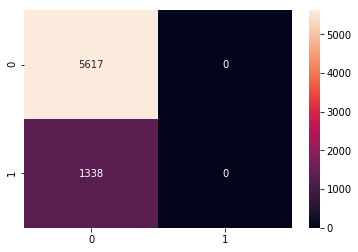

In [119]:
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score, accuracy_score, precision_score, recall_score

# Initialize the classifier
clf = LogisticRegression(random_state=2018)

# Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = {'C' : [0.001,0.01,0.1,1,10,100,1000], 'solver' : ['newton-cg', 'lbfgs', 'liblinear']}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, param_grid=parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final precision score on the testing data: {:.4f}".format(precision_score(y_test, best_predictions)))
print("Final recall score on the testing data: {:.4f}".format(recall_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))


# Suggestions from Udacity
print('best_clf ： ', best_clf, '\n')

from sklearn.metrics import confusion_matrix
import seaborn as sns
%matplotlib inline
pred = best_clf.predict(X_test)
sns.heatmap(confusion_matrix(y_test, pred), annot = True, fmt = '')

### Prediction


In [108]:
test_features.columns

Index(['order_id', 'group_id', 'source_1', 'source_2', 'unit', 'people_amount',
       'order_year', 'order_month', 'order_day', 'order_dayofyear',
       'order_weekday', 'go_time', 'back_time', 'go_route_num',
       'back_route_num', 'fly_time', 'sub_line', 'area', 'days', 'begin_date',
       'price', 'begin_year', 'begin_month', 'begin_day', 'begin_dayofyear',
       'begin_weekday', 'end_year', 'end_month', 'end_day', 'end_dayofyear',
       'end_weekday', 'date_diff_order_begin', ' deal_or_not'],
      dtype='object')

In [109]:
test_features = test_features.fillna(0)   ## TODO:  fillna考慮 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
test_features_X = test_features.drop(['order_id', 'group_id', 'begin_date', ' deal_or_not'], axis=1)
final_predictions = best_clf.predict(test_features_X)

## Modeling 2 : Random Forest

In [98]:
from sklearn.ensemble import RandomForestClassifier

/Users/kuanyao.huang/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [100]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [111]:
rf_predictions = rf_model.predict(X_test)


Optimized Model
------
Final accuracy score on the testing data: 0.8029
Final precision score on the testing data: 0.4631
Final recall score on the testing data: 0.1547
Final F-score on the testing data: 0.3311


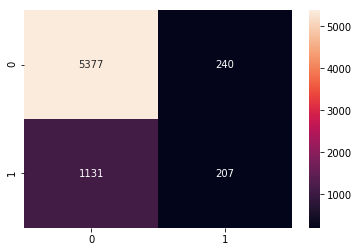

In [120]:
# Report the before-and-afterscores
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, rf_predictions)))
print("Final precision score on the testing data: {:.4f}".format(precision_score(y_test, rf_predictions)))
print("Final recall score on the testing data: {:.4f}".format(recall_score(y_test, rf_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, rf_predictions, beta = 0.5)))



from sklearn.metrics import confusion_matrix
import seaborn as sns
%matplotlib inline
pred = rf_model.predict(X_test)
sns.heatmap(confusion_matrix(y_test, pred), annot = True, fmt = '')

In [115]:
rf_final_predictions = rf_model.predict(test_features_X)

In [118]:
rf_final_predictions[:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])